
Data Overview:
         invoice_id   unit_price     quantity date       rating  \
count   9969.000000  9969.000000  9969.000000    0  9969.000000   
mean    5010.116561    50.622142     2.355602  NaT     5.828839   
min        1.000000    10.080000     1.000000  NaT     3.000000   
25%     2524.000000    32.000000     1.000000  NaT     4.000000   
50%     5016.000000    51.000000     2.000000  NaT     6.000000   
75%     7508.000000    69.000000     3.000000  NaT     7.000000   
max    10000.000000    99.960000    10.000000  NaT    10.000000   
std     2886.217349    21.203766     1.605455  NaN     1.763723   

       profit_margin  total_amount  
count    9969.000000   9969.000000  
mean        0.393744    121.348819  
min         0.180000     10.170000  
25%         0.330000     54.000000  
50%         0.330000     88.000000  
75%         0.480000    156.000000  
max         0.570000    993.000000  
std         0.090659    112.678040  


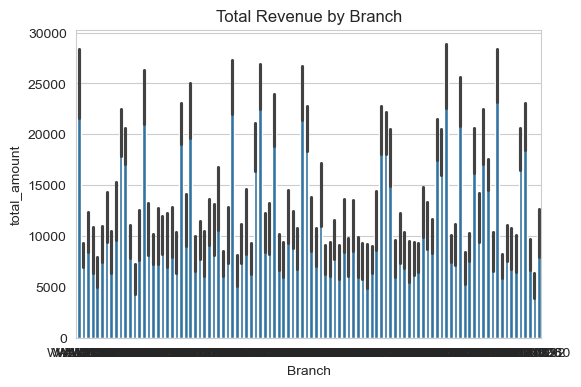

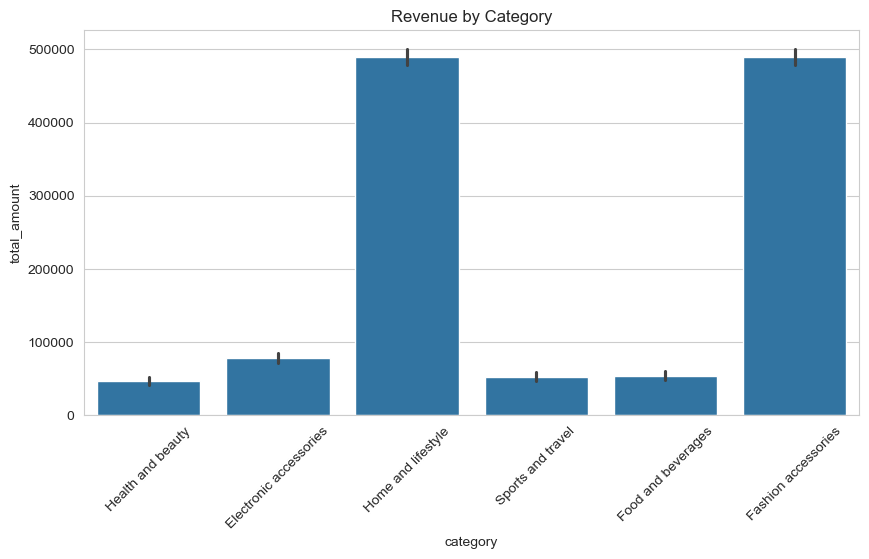

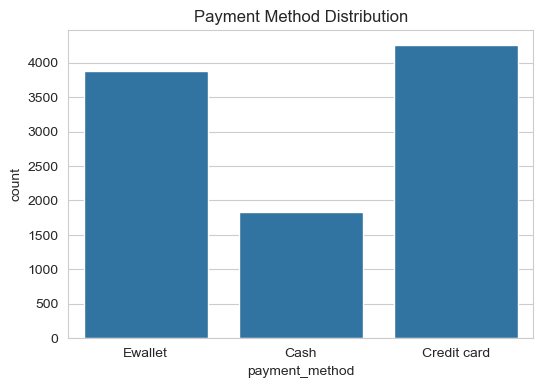

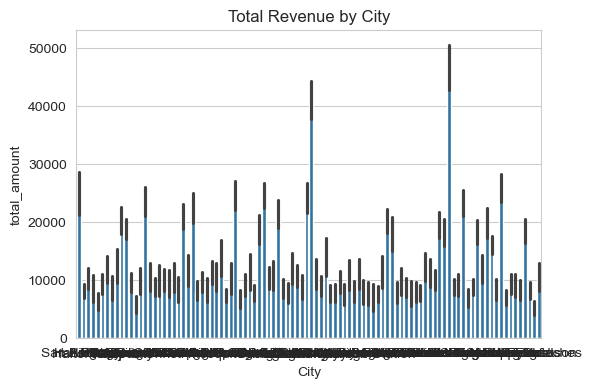

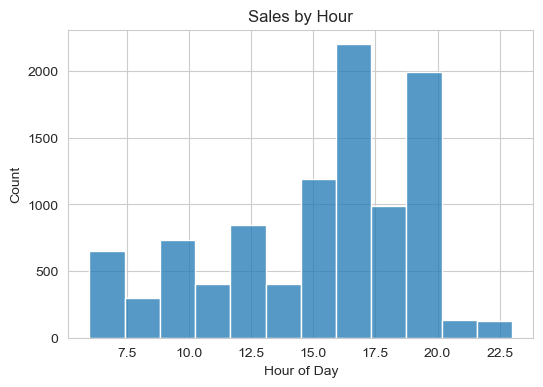

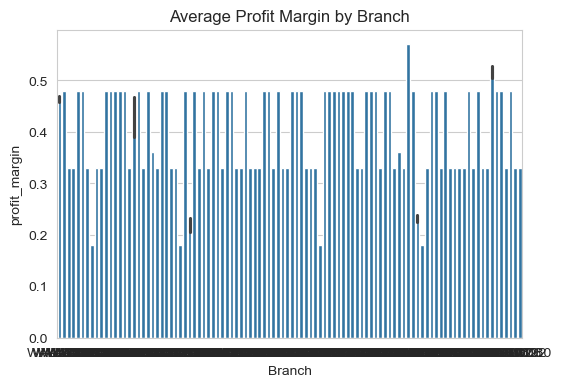

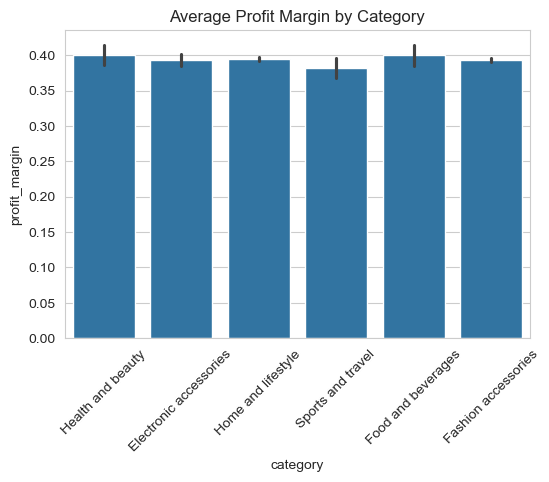

Job completed successfully


In [16]:
# Walmart Data Analysis Project

# Step 1: Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import os
import datetime
import numpy as np

# Step 2: Loading the CSV file
file_path = "data/Walmart.csv"
df = pd.read_csv(file_path)

# Step 3: Cleaning the data
# Remove duplicate entries
df.drop_duplicates(inplace=True)

# Remove rows with missing values to make things simple
df.dropna(inplace=True)

# Converting the 'date' column to proper datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce').dt.date

# Making sure 'quantity' column is in integer type
df['quantity'] = df['quantity'].astype(int)

# Step 4: Converting currency strings to float for calculation
currency_cols = ['unit_price']
for col in currency_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Step 5: Feature Engineering - Let's calculate the total amount of each transaction
df['total_amount'] = df['unit_price'] * df['quantity']

# Step 6: Checking basic stats to understand our data better
print("\nData Overview:")
print(df.describe())

# Step 7: Saving cleaned data for backup or other use
os.makedirs("output", exist_ok=True)
df.to_csv("output/walmart_cleaned_dataset.csv", index=False)

# Step 8: MySQL Integration
# I set up MySQL locally, created a database named 'st_project_1', and now I'm inserting the cleaned data there.
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="sss123SSS",
    database="st_project_1"
)
cursor = conn.cursor()

# Creating a table that matches our dataset
cursor.execute("""
    CREATE TABLE IF NOT EXISTS walmart_dataset (
        invoice_id VARCHAR(30),
        Branch VARCHAR(10),
        City VARCHAR(30),
        category VARCHAR(50),
        unit_price FLOAT,
        quantity INT,
        date DATE,
        time TIME,
        payment_method VARCHAR(30),
        rating FLOAT,
        profit_margin FLOAT,
        total_amount FLOAT
    );
""")

# Converting each row into a format MySQL can accept easily
def convert_for_mysql(row):
    row = list(row)
    row[6] = row[6] if isinstance(row[6], datetime.date) and not pd.isna(row[6]) else None
    row[7] = row[7] if isinstance(row[7], str) else None
    for i in range(len(row)):
        if isinstance(row[i], (np.generic, np.datetime64)):
            row[i] = row[i].item() if not pd.isna(row[i]) else None
    return tuple(row)

# Inserting all rows into the MySQL table
data_tuples = [convert_for_mysql(x) for x in df.values]
sql_query = "INSERT INTO walmart_dataset VALUES (" + ",".join(["%s"] * len(df.columns)) + ")"
for row in data_tuples:
    cursor.execute(sql_query, row)

conn.commit()
cursor.close()
conn.close()

# Step 9: Data Visualization plottingg Graphs
sns.set_style("whitegrid")

# Revenue by Branch
plt.figure(figsize=(6,4))
sns.barplot(x='Branch', y='total_amount', data=df, estimator=sum)
plt.title("Total Revenue by Branch")
plt.show()

# Revenue by Category
plt.figure(figsize=(10,5))
sns.barplot(x='category', y='total_amount', data=df, estimator=sum)
plt.title("Revenue by Category")
plt.xticks(rotation=45)
plt.show()

# Payment Method Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='payment_method', data=df)
plt.title("Payment Method Distribution")
plt.show()

# Revenue by City
plt.figure(figsize=(6,4))
sns.barplot(x='City', y='total_amount', data=df, estimator=sum)
plt.title("Total Revenue by City")
plt.show()

# Sales by Hour (let's see what time people shop the most)
plt.figure(figsize=(6,4))
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour
sns.histplot(df['hour'], bins=12, kde=False)
plt.title("Sales by Hour")
plt.xlabel("Hour of Day")
plt.show()

# Average Profit Margin by Branch
plt.figure(figsize=(6,4))
sns.barplot(x='Branch', y='profit_margin', data=df, estimator=np.mean)
plt.title("Average Profit Margin by Branch")
plt.show()

# Average Profit Margin by Category
plt.figure(figsize=(6,4))
sns.barplot(x='category', y='profit_margin', data=df, estimator=np.mean)
plt.title("Average Profit Margin by Category")
plt.xticks(rotation=45)
plt.show()

# All done
print("Job completed successfully")